In [2]:
# Célula para baixar os dados. Execute apenas uma vez!
from torchvision.datasets.utils import download_and_extract_archive

def download(root):

    url_images = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz'
    url_targets = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz'

    download_and_extract_archive(url_images, root, remove_finished=False)
    download_and_extract_archive(url_targets, root, remove_finished=False)

#download('../data/oxford_pets')

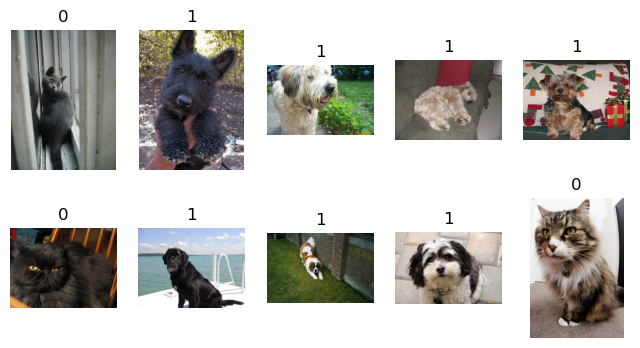

In [3]:

from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transf

class OxfordPets(Dataset):

    def __init__(self, root, transforms=None):

        root = Path(root)
        images_folder = root / "images"
        anns_file = root / "annotations/list.txt"

        images = []
        labels = []
        for line in open(anns_file).read().splitlines():
            if line[0]!="#":   # Remove comentários do arquivo
                name, class_id, species_id, breed_id = line.strip().split()
                images.append(images_folder/f'{name}.jpg')
                # -1 para começar em 0
                labels.append(int(species_id)-1)

        self.classes = ['Cat', 'Dog']
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image,label
    
    def __len__(self):
        return len(self.images)
    
    
def plot_examples(data):

    fig, axs = plt.subplots(2, 5, figsize=(8,4))
    axs = axs.reshape(-1)
    for (img, text), ax in zip(data, axs):
        ax.imshow(img)
        ax.set_title(text)
        ax.set_axis_off()
        
ds = OxfordPets('../data/oxford_pets')
img, target = ds[0]

data = [ds[idx] for idx in torch.randint(0, len(ds), (10,))]
plot_examples(data)

In [4]:
%%time
import numpy as np

def get_statistics(ds):

    n = len(ds)
    mean = np.zeros(3)
    std = np.zeros(3)
    classes = np.array([0,0])
    shapes = np.array([np.inf, -1])  # Armazena o menor e maior tamanho
    for img, target in ds:
        img_np = np.array(img)
        mean += np.mean(img_np, axis=(0,1))
        std += np.std(img_np, axis=(0,1))
        classes[target] += 1

        # Cálculo do menor e maior tamanho de imagens
        shapes[0] = min([shapes[0], img_np.shape[0], img_np.shape[1]])
        shapes[1] = max([shapes[1], img_np.shape[0], img_np.shape[1]])
    mean /= n
    std /= n

    return mean, std, classes, shapes

# Essa função demora para executar
print(get_statistics(ds))

(array([122.74826669, 114.59060423, 100.92046647]), array([59.15813574, 58.44060243, 58.96353786]), array([2371, 4978]), array([ 103., 3264.]))
CPU times: total: 2min 21s
Wall time: 3min 40s


In [5]:
n1 = 2371  # Nro de imagens na classe gato
n2 = 4978  # Nro de imagens na classe cachorro
weights = (n2/(n1+n2), n1/(n1+n2))
print(weights)

(0.6773710708939992, 0.32262892910600083)


In [6]:
transforms = transf.Compose([
    transf.PILToTensor(),
    transf.RandomResizedCrop(size=(224,224), scale=(0.5,1.), ratio=(0.7,1.3)),
    transf.RandomHorizontalFlip(),
    transf.ToDtype(torch.float32),
    transf.Normalize(mean=(122.7, 114.6, 100.9), std=(59.0,58.0,59.0))
])

ds = OxfordPets('../data/oxford_pets',transforms)
ds[0][0]

tensor([[[-1.4186, -1.3847, -1.3508,  ...,  2.2254,  2.2254,  2.2254],
         [-1.3847, -1.4017, -1.3339,  ...,  2.2424,  2.2424,  2.2424],
         [-1.3169, -1.3508, -1.2831,  ...,  2.2424,  2.2424,  2.2424],
         ...,
         [-0.2831, -1.3508, -1.9610,  ...,  2.0898,  1.6661,  0.3949],
         [-0.8254, -0.1475, -1.3678,  ...,  0.3441,  0.1915, -0.2492],
         [-1.5712, -0.1983, -0.8254,  ..., -0.3678, -0.9610, -1.0288]],

        [[-1.6138, -1.5793, -1.5966,  ...,  2.4034,  2.4034,  2.4034],
         [-1.5793, -1.5793, -1.6138,  ...,  2.4207,  2.4207,  2.4207],
         [-1.5966, -1.6138, -1.5448,  ...,  2.4207,  2.4207,  2.4207],
         ...,
         [-0.1483, -1.2000, -1.8034,  ...,  2.3345,  2.0069,  1.1621],
         [-0.7345, -0.0103, -1.2517,  ...,  0.9897,  0.9897,  0.6448],
         [-1.4931, -0.0621, -0.7172,  ...,  0.3862, -0.1138, -0.1483]],

        [[-1.4729, -1.4898, -1.4898,  ...,  2.6119,  2.6119,  2.5949],
         [-1.4898, -1.5237, -1.5068,  ...,  2

In [7]:
%%time
dl = DataLoader(ds, batch_size=8, num_workers=8)
for imgs, targets in dl:
    pass